# __Scenario B:__<br>α-glucosidase inhibition by fucoidan

Data provided by Chantal Daub (Biochemistry, Rhodes University, Makhanda, South Africa)

## Project background
In this scenario, the inhibitory properties of fucoidan on $\alpha$-glucosidase from *Saccharomyces cerevisiae* was investigated. Fucoidan is a sulfated polysaccharide found in various brown algae. The polysaccaride is investigated as a potential active compound in the fields of anit-cancer, anti-inflammation, and anti-coagulate research, among others ({cite:t}`li2008fucoidan`). Recently, {cite:t}`daub2020fucoidan` proposed the application of fucoidan as a drug for the treatment of diabetes mellitus, since fucoidan effectively inhibit $\alpha$-glucosidase. In the corresponding study, fucoidan from *E. maxima* showed an almost 2-fold lower IC<sub>50</sub> value, compared to established diabetes drug acarbose.  
In the following analysis, $\alpha$-glucosidase was exposed to fucoidan from *Ecklonia maxima*, *Ecklonia radiata*, *Fucus vesiculosus*, and *Schimmelmannia elegans* to test their respective inhibition abilities.

### Experimental design 
$\alpha$-glucosidase reactions, catalyzing the hydrolysis of p-nitrophenyl glucopyranoside (p-NPG) to p-nitrophenol were conducted with and without fucoidan from each seaweed species as well as acarbose. Thereby, fucoidan was applied in two different concentrations. p-NPG was applied in a range from 0.1 mM to 5 mM, to enzyme reactions containing 9.19 µM $\alpha$-glucosidase
Product formation was recorded photometrically at 405 nm and 37°C for 20 min. Product concentrations were calculated utilizing a photometric p-NP standard. Additionally control reaction without enzyme were prepared to subtract the absorption contribution of the respective inhibitor, buffer, enzyme and substrate.


## Data preparation

### Imports and parser function

In [66]:
from typing import Dict
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import re
import os
import pyenzyme as pe
from IPython.display import display
from CaliPytion.tools.standardcurve import StandardCurve
from EnzymePynetics.tools.parameterestimator import ParameterEstimator


import warnings
warnings.filterwarnings('ignore')

colors = list(mcolors.TABLEAU_COLORS.values())

# Parser
def measurement_data_to_EnzymeML(
    template_path: str,
    measurement_data: np.ndarray,
    species_id: str,
    time: np.ndarray,
    data_unit: str,
    time_unit: str
    ) -> pe.EnzymeMLDocument:

    enzmldoc: pe.EnzymeMLDocument = pe.EnzymeMLDocument.fromTemplate(template_path)

    for IDs, concentration in zip(enzmldoc.measurement_dict.keys(), measurement_data):
        for counter, replicate in enumerate(concentration):
            
            enzmldoc.getMeasurement(IDs).addReplicates(pe.Replicate(
                id=f"Measurement{counter}",
                species_id=species_id,
                data=list(replicate),
                data_unit=data_unit,
                time=list(time),
                time_unit=time_unit), enzmldoc)

    return enzmldoc

# Ignore hidden files in file stystem
def listdir_nohidden(path):
    for f in os.listdir(path):
        if not f.startswith('.'):
            yield f

Measurement data was provided as an excel file, whereas metadata was filled in EnzymeML Excel templates for each fucoidan seaweed species and acarbose respectively. In preliminary experiments, p-NPG showed to  absorb at the product detection wavelength slightly. Therefore, the absorbance contribution of substrate at the product absorption wavelength was subtracted as well as the the contributions of enzyme, buffer and inhibitor. Then, the blanked absorbance data was written to the EnzymeML documents by a parser function.

In [67]:
dataset_path = "../../data/glucosidase_inhibition/experimental_data_real.xlsx"
template_directory = "../../data/glucosidase_inhibition/EnzymeML_templates"   

enzml_docs = []
# Load experimental data from Excel
excel_sheets = sorted(pd.ExcelFile(dataset_path).sheet_names)
inhibitors = excel_sheets[:-1]
substrate_controls = excel_sheets[-1]
initial_substrates = [0.1, 0.25, 0.5, 1, 2.5, 5] # mM

# Blank data
## Absorption contribution from substrate
substrate_absorption_data = pd.read_excel(dataset_path, sheet_name=substrate_controls).set_index("time")
buffer_enzyme_absorption = np.mean(substrate_absorption_data.iloc[:,0])
substrate_absorptions = substrate_absorption_data.subtract(buffer_enzyme_absorption).drop(columns=["Buffer+ Enzyme"])
substrate_absorptions = substrate_absorptions.values.T.reshape(2,6,21)
substrate_absorptions = np.mean(substrate_absorptions, axis=0)
substrate_absorptions = np.mean(substrate_absorptions, axis=1)
mapper_substrate_enzyme_absorption = dict(zip(initial_substrates, substrate_absorptions))

for inhibitor, template in zip(sorted(inhibitors), sorted(listdir_nohidden(template_directory))):
    df = pd.read_excel(dataset_path, sheet_name=inhibitor).set_index("time")
    time = df.index.values
    inhibitor_controls = df.iloc[:,:4]
    inhibitor_concs = np.unique([float(conc.split(" ")[-2]) for conc in inhibitor_controls.columns])
    inhibitor_absorptions = inhibitor_controls.values.T.reshape(2,2,21)
    inhibitor_absorptions = np.mean(inhibitor_absorptions, axis=1)
    inhibitor_absorptions = np.mean(inhibitor_absorptions, axis=1)
    mapper_inhibitor_absorption = dict(zip(inhibitor_concs, inhibitor_absorptions))
    mapper_inhibitor_absorption[0.0] = buffer_enzyme_absorption
    df = df.iloc[:,4:]
    for column in df.columns:
        init_substrate = float(column.split(" ")[4])
        inhibitor_conc = float(column.split(" ")[1])
        df[column] = df[column] - mapper_substrate_enzyme_absorption[init_substrate] 
        df[column] = df[column] - mapper_inhibitor_absorption[inhibitor_conc]
    
    data = df.values.T.reshape(3,2,6,21)
    data = np.moveaxis(data,1,2).reshape(18,2,21)

    # Parse measurement data to EnzymeML documents
    enzml_docs.append(measurement_data_to_EnzymeML(
        template_path=f"{template_directory}/{template}",
        measurement_data=data,
        time=time,
        species_id="s1",
        data_unit="mmole / l",
        time_unit="min"
    ))

### Data quality

In the next cell, the blanked absorption data of each EnzymeML document is visualized with the ```.visualize()```-method of PyEnzyme for quality control.

a-glucosidase inhibition by acarbose


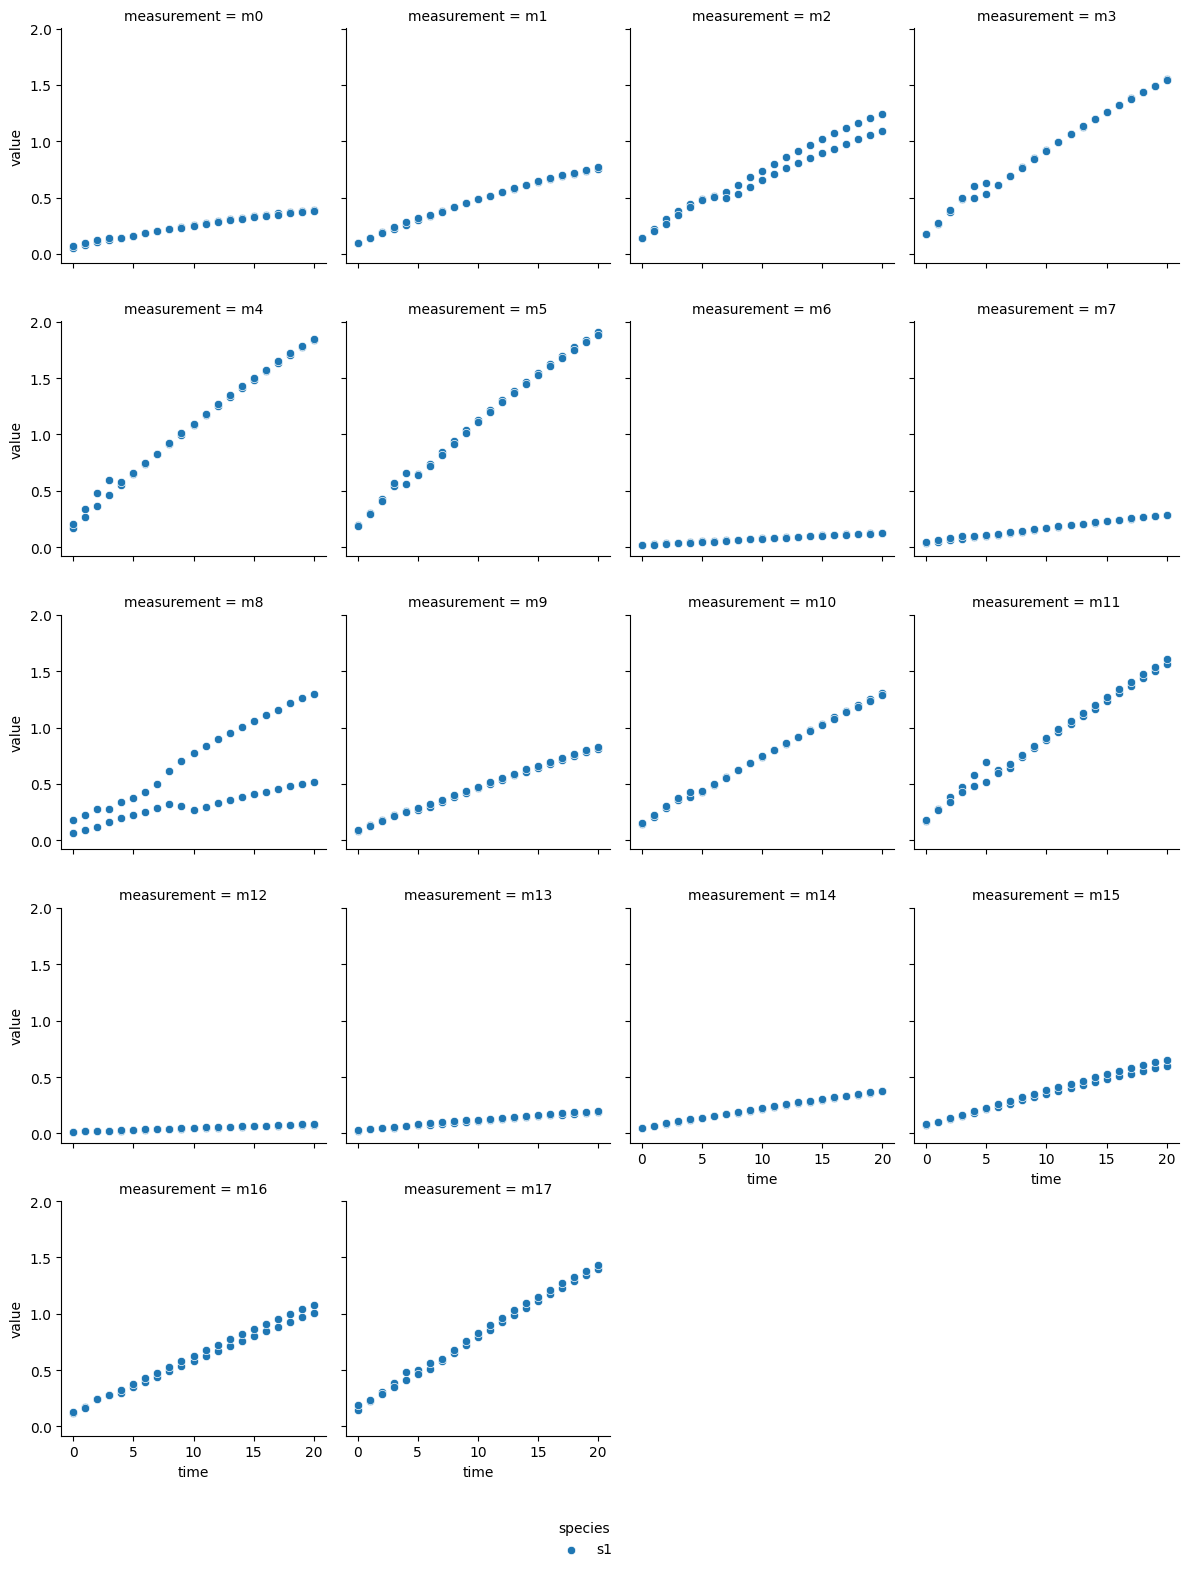

a-glucosidase inhibition by fucoidan from E. maxima


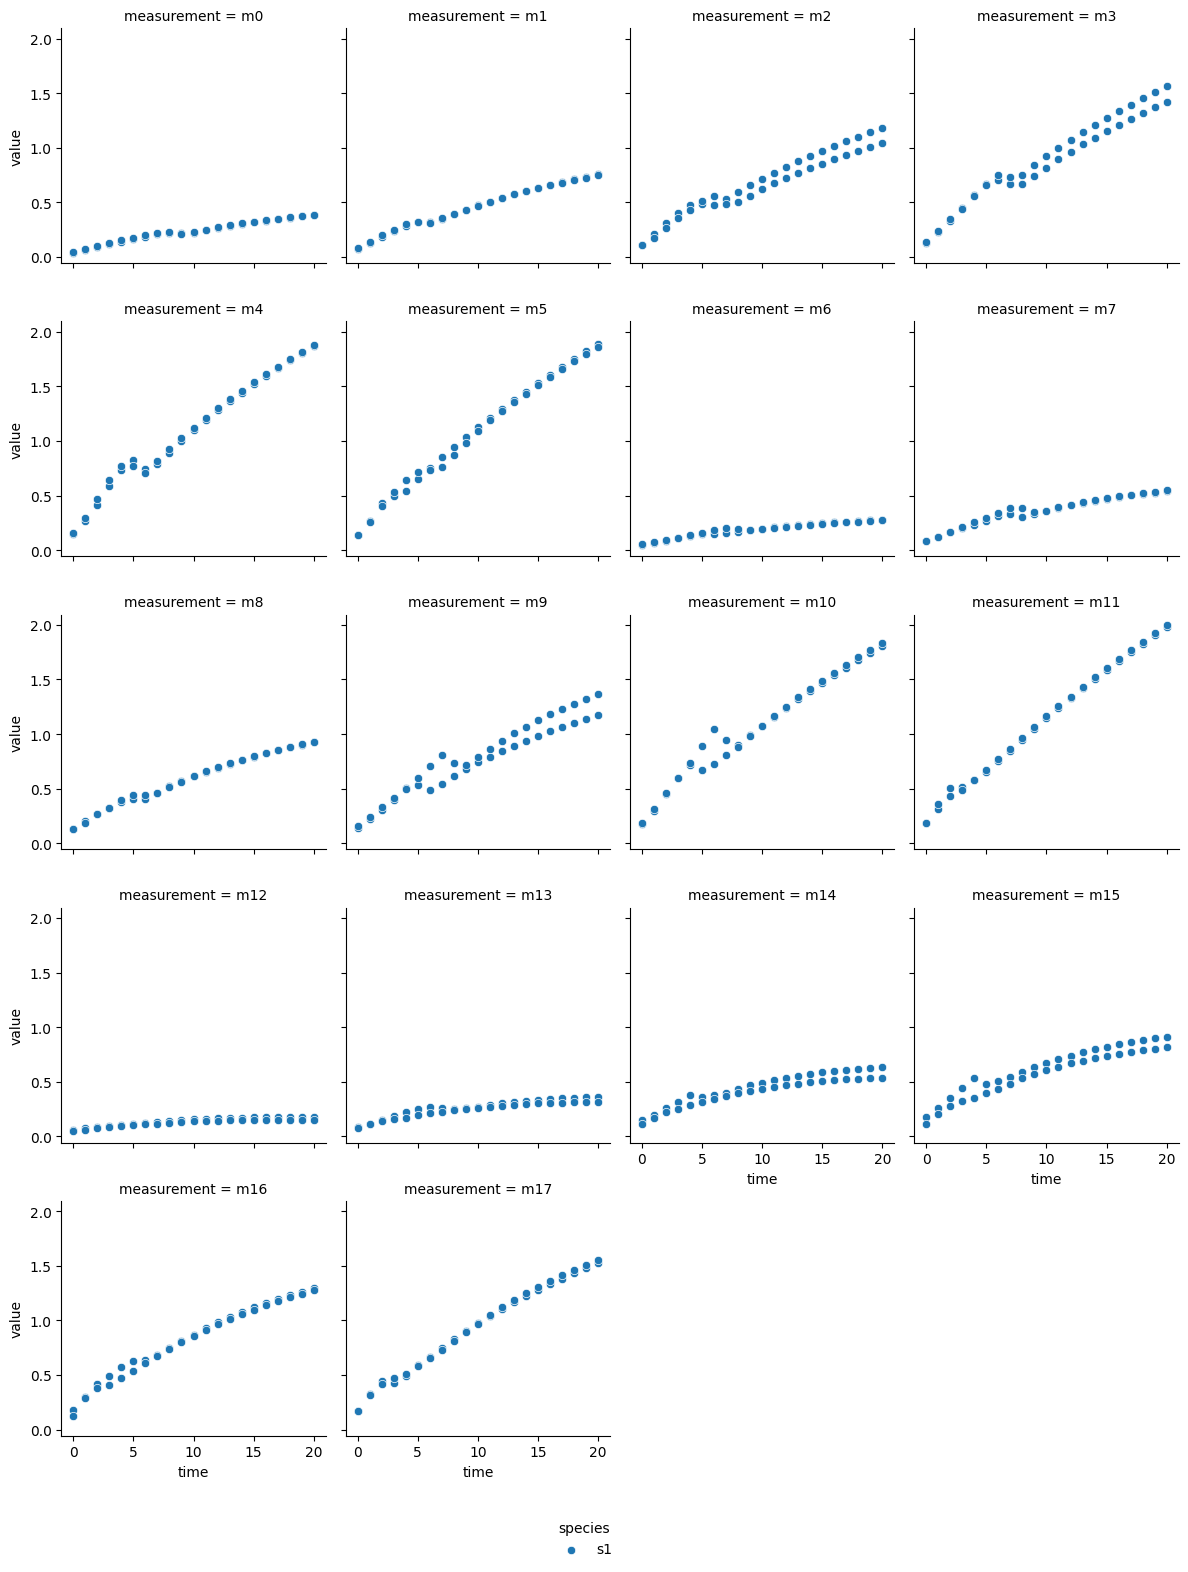

a-glucosidase inhibition by fucoidan from E. radiata


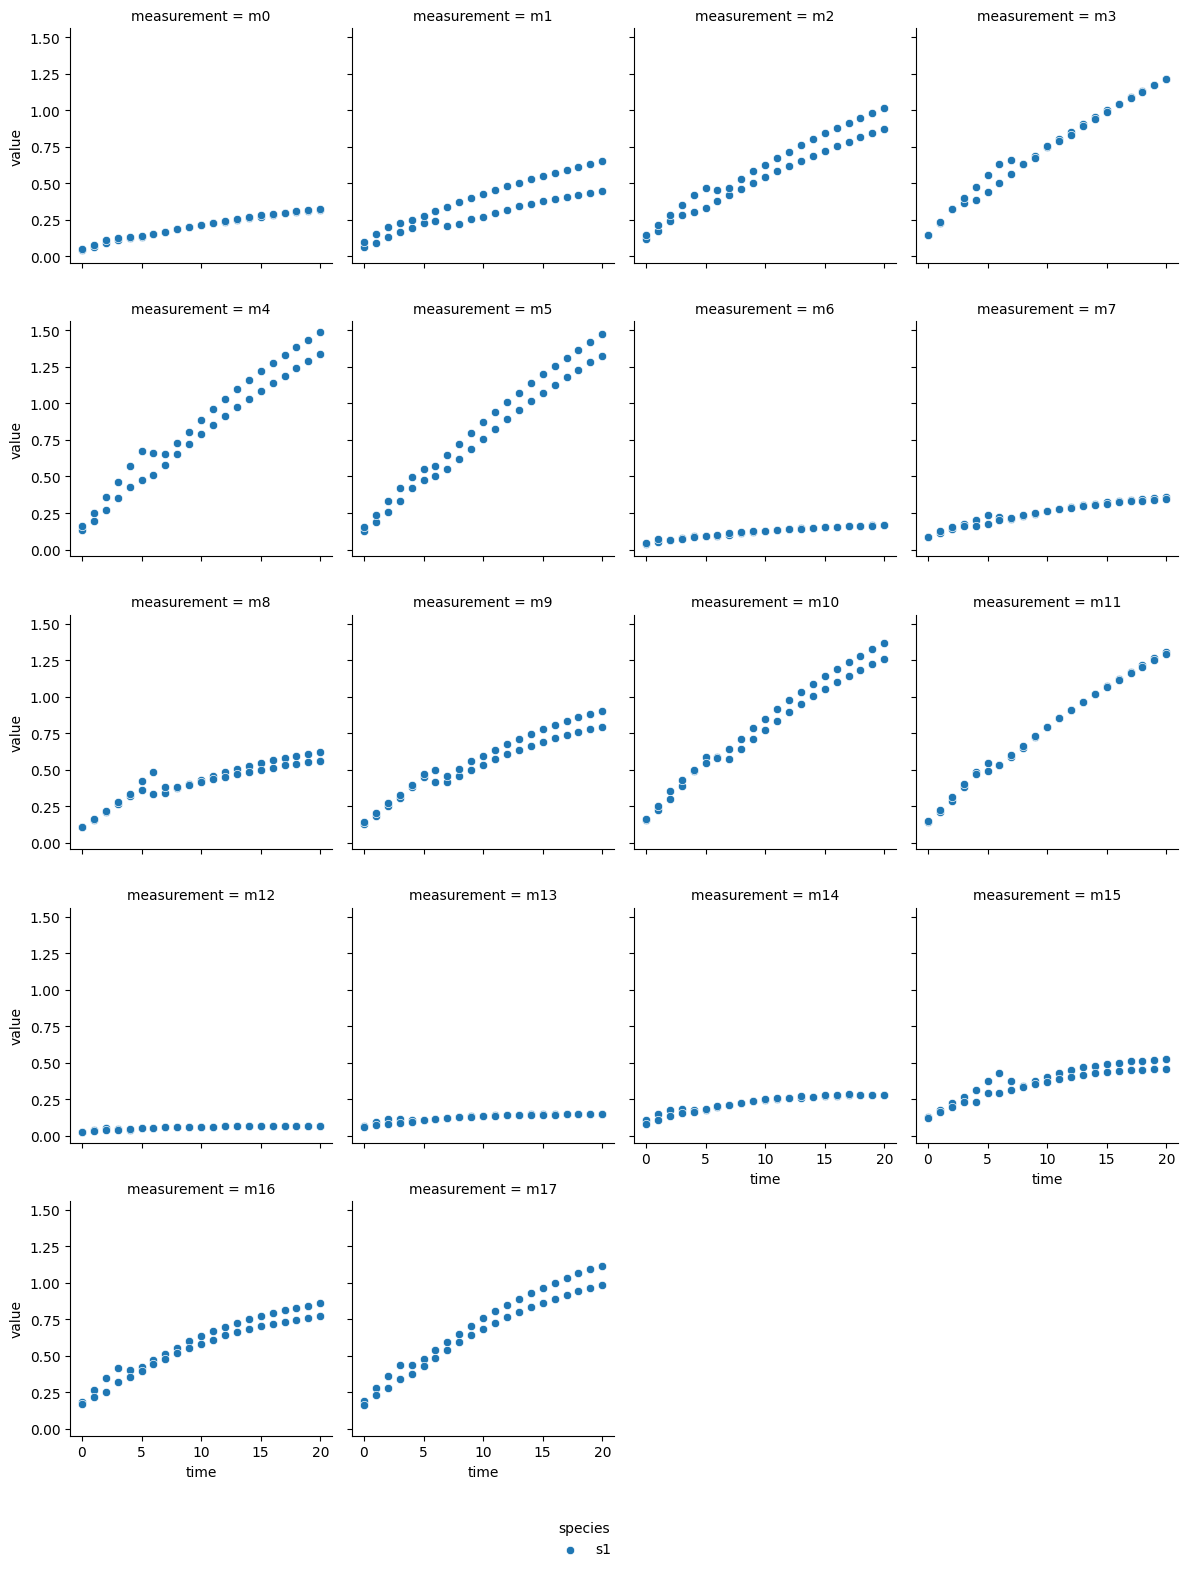

a-glucosidase inhibition by fucoidan from F. versiculosus


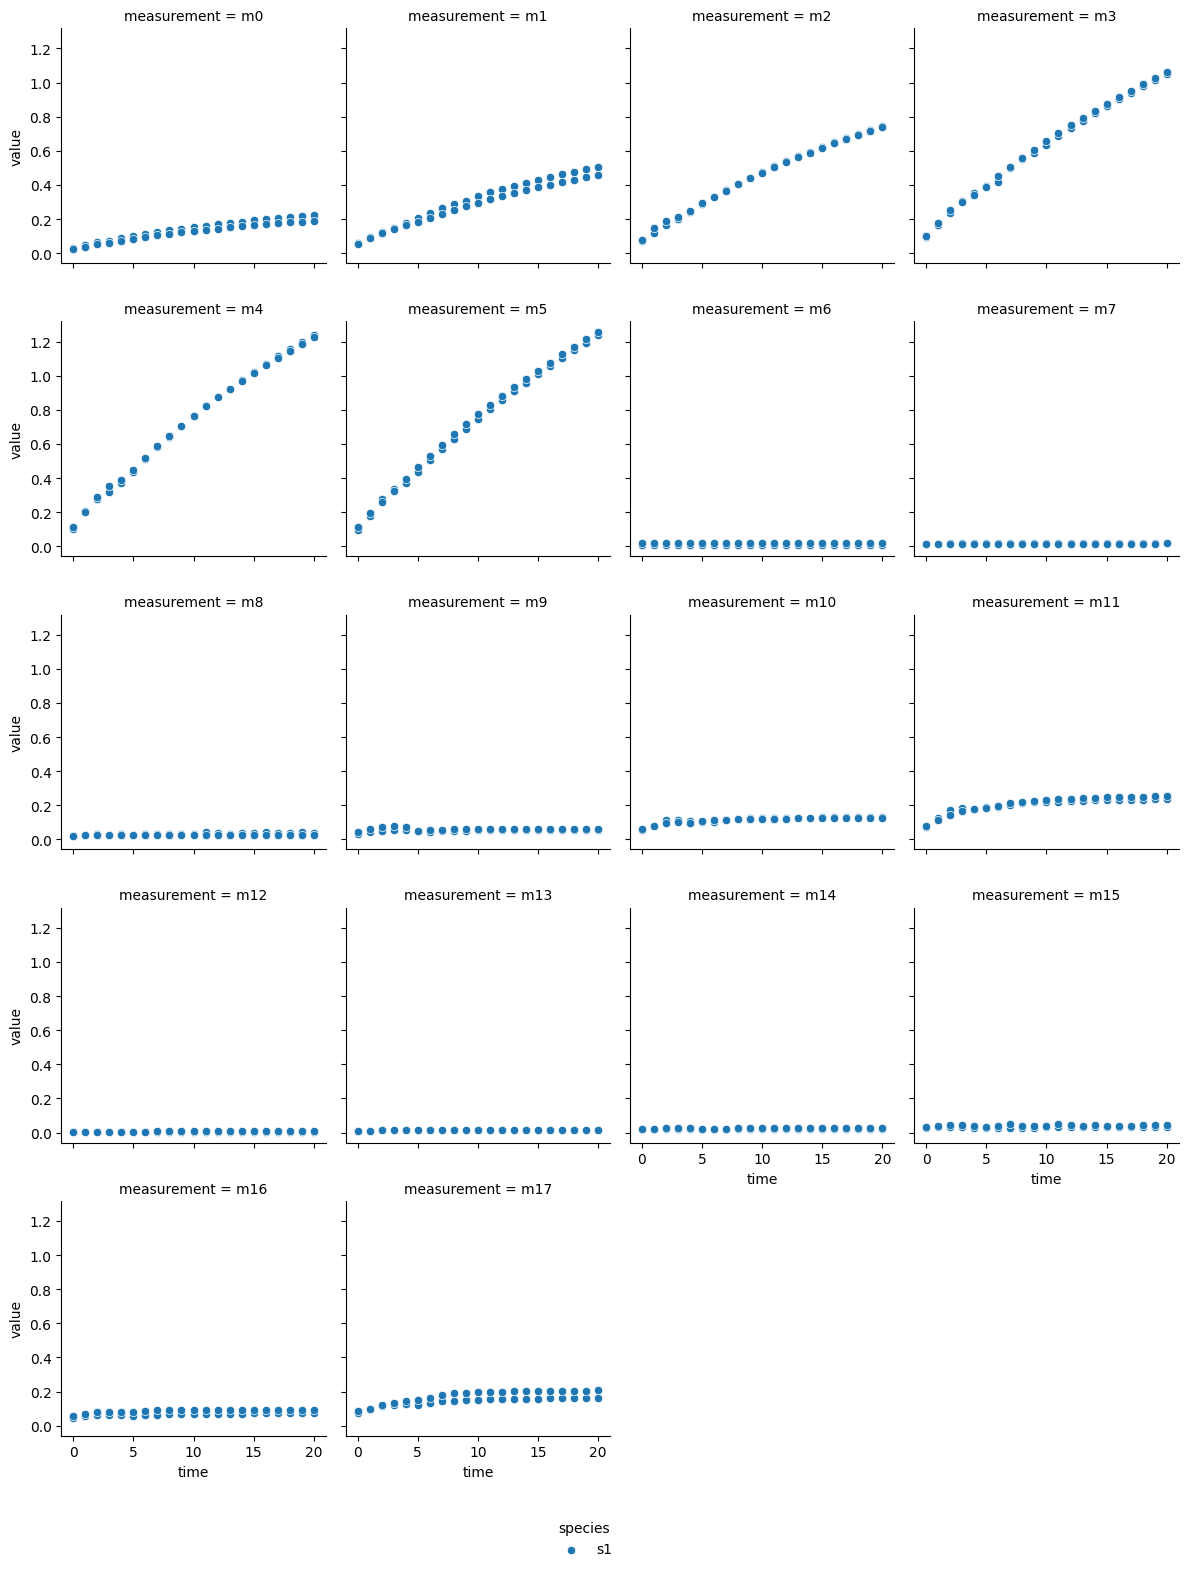

a-glucosidase inhibition by fucoidan from S. elegans


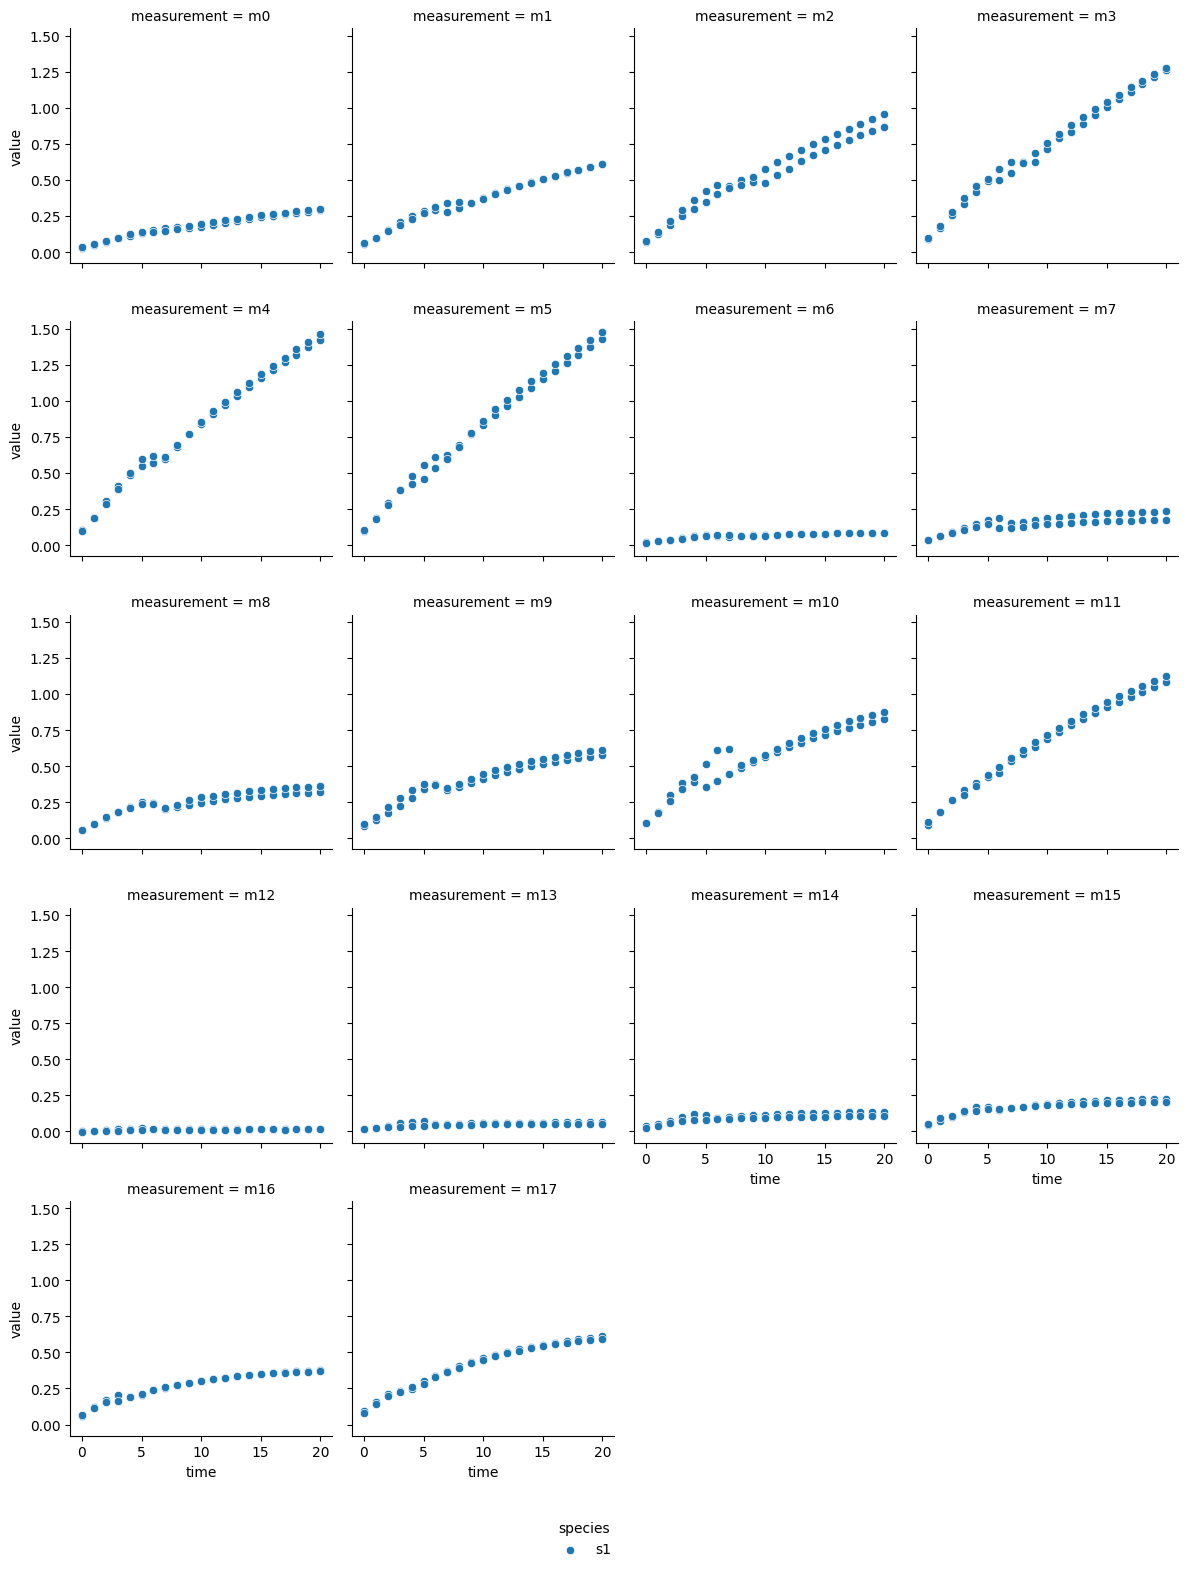

In [68]:
for doc in enzml_docs:
    print(doc.name)
    doc.visualize()
    plt.show()

In [69]:
del enzml_docs[0].measurement_dict["m8"].getReactant("s1").replicates[0]

The technical output of the cell above visualizes the blanked product absorbance data of each dataset. Therein, the individual measurements are labeled from m0 - m17, which represent individual experimental conditions. Thereby, measurements m0 - m5 are from reactions without inhibitor, m6 - m11 reactions with the lower inhibitor concentration, and m12 - m17 originate from reactions with the higher inhibitor concentration. Each subplot contains the data of two experimental repeats.  
In most reactions a decrease followed by an increase of reaction rate is visible around minute 5. Since each dataset originates from a continuous photometric measurement carried out on a single MTP, the observed behavior likely sources from an analytical device malfunction.

### Concentration calculation

Standard data of p-NP was loaded from an excel file, and a standard curve was created. Then, the standard curve was applied to the EnzymeML documents.

Calibration data was automatically blanked.


,AIC
3rd polynominal,-135
Quadratic,-135
Rational,-135
Linear,-125
Exponential,-11


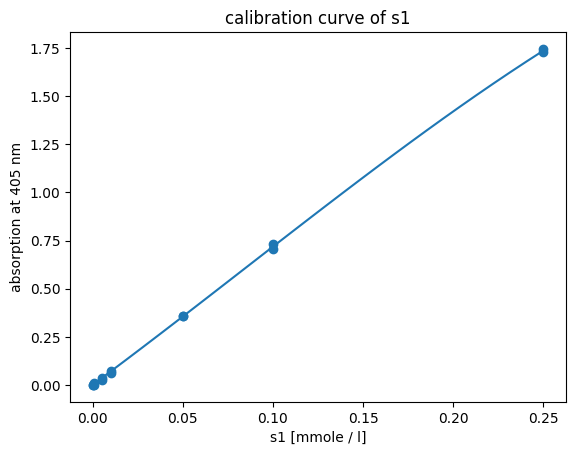

In [70]:
path_calibration_data = "../../data/glucosidase_inhibition/p-NP_standard.xlsx"


product_standard = StandardCurve.from_excel(
    path=path_calibration_data,
    reactant_id="s1", 
    sheet_name="csv", 
    wavelength=405, 
    concentration_unit = "mmole / l", 
    cutoff_absorption=2)

product_standard.visualize()

# Apply calibration curves to absorption EnzymeML documents
for enzmldoc in enzml_docs:
    product_standard.apply_to_EnzymeML(enzmldoc, "s1")

### Parameter estimation

Due to the mentioned issue with the measurement data after minute 5, only data of the initial 2 minutes was used for parameter estimation. Additionally, the faulty measurement with an initial substrate concentration of 0.5 mM from the 'a-glucosidase inhibition by acarbose' data set was excluded from parameter estimation. All data sets were fitted against all inhibition models of EnzmePynetics.

In [77]:
# Run parameter estimation for all data sets
results=[]
for enzmldoc in enzml_docs:
    result = ParameterEstimator.from_EnzymeML(enzmldoc=enzmldoc, reactant_id="s1", inhibitor_id="s2", measured_species="product")
    result.fit_models(enzyme_inactivation=False, display_output=False, stop_time_index=3)
    results.append(result)
    print(f" Result overview for {result.data.title}")
    display(result.result_dict)
    

 Result overview for a-glucosidase inhibition by acarbose


,AIC,kcat [1/min],Km [mmole / l],kcat / Km [1/min * 1/mmole / l],Ki competitive [g / l],Ki uncompetitive [g / l]
non-competitive inhibition,-1342,1.939 +/- 2.78%,0.353 +/- 10.47%,5.486 +/- 10.83%,0.158 +/- 15.96%,2.883 +/- 33.44%
competitive inhibition,-1334,1.886 +/- 2.71%,0.326 +/- 10.73%,5.779 +/- 11.06%,0.112 +/- 10.77%,-
partially competitive inhibition,-1332,1.887 +/- 2.73%,0.327 +/- 10.80%,5.778 +/- 11.14%,0.110 +/- 12.41%,58.221 +/- 283.72%
uncompetitive inhibition,-1242,2.170 +/- 4.83%,0.659 +/- 13.96%,3.293 +/- 14.77%,-,0.632 +/- 11.75%
irreversible Michaelis Menten,-1145,1.557 +/- 7.09%,0.704 +/- 22.31%,2.213 +/- 23.41%,-,-


 Result overview for a-glucosidase inhibition by fucoidan from E. maxima


,AIC,kcat [1/min],Km [mmole / l],kcat / Km [1/min * 1/mmole / l],Ki competitive [g / l],Ki uncompetitive [g / l]
competitive inhibition,-1359,2.409 +/- 1.81%,0.442 +/- 7.53%,5.454 +/- 7.75%,1.091 +/- 17.02%,-
partially competitive inhibition,-1359,2.411 +/- 1.83%,0.434 +/- 7.78%,5.558 +/- 7.99%,0.381 +/- 80.15%,1.080 +/- 124.57%
non-competitive inhibition,-1356,2.427 +/- 2.00%,0.452 +/- 7.91%,5.367 +/- 8.15%,1.170 +/- 18.88%,53.488 +/- 123.08%
uncompetitive inhibition,-1320,2.549 +/- 3.01%,0.650 +/- 7.49%,3.922 +/- 8.07%,-,7.353 +/- 32.54%
irreversible Michaelis Menten,-1312,2.407 +/- 2.30%,0.625 +/- 7.37%,3.851 +/- 7.72%,-,-


 Result overview for a-glucosidase inhibition by fucoidan from E. radiata


,AIC,kcat [1/min],Km [mmole / l],kcat / Km [1/min * 1/mmole / l],Ki competitive [g / l],Ki uncompetitive [g / l]
competitive inhibition,-1358,1.347 +/- 2.69%,0.173 +/- 14.49%,7.765 +/- 14.74%,0.028 +/- 19.09%,-
non-competitive inhibition,-1358,1.384 +/- 3.44%,0.189 +/- 15.64%,7.315 +/- 16.02%,0.034 +/- 24.94%,1.043 +/- 77.78%
partially competitive inhibition,-1356,1.346 +/- 2.73%,0.173 +/- 14.69%,7.780 +/- 14.94%,0.028 +/- 21.14%,8.170 +/- 488.67%
uncompetitive inhibition,-1313,1.517 +/- 4.35%,0.367 +/- 13.02%,4.133 +/- 13.73%,-,0.208 +/- 19.26%
irreversible Michaelis Menten,-1281,1.288 +/- 3.93%,0.352 +/- 14.58%,3.658 +/- 15.10%,-,-


 Result overview for a-glucosidase inhibition by fucoidan from F. versiculosus


,AIC,kcat [1/min],Km [mmole / l],kcat / Km [1/min * 1/mmole / l],Ki competitive [g / l],Ki uncompetitive [g / l]
competitive inhibition,-1520,1.482 +/- 2.02%,0.405 +/- 7.28%,3.656 +/- 7.55%,0.003 +/- 7.75%,-
non-competitive inhibition,-1518,1.482 +/- 2.00%,0.405 +/- 7.24%,3.658 +/- 7.51%,0.003 +/- 15.43%,16.239 +/- 8645.47%
partially competitive inhibition,-1518,1.482 +/- 2.07%,0.405 +/- 7.38%,3.658 +/- 7.67%,0.003 +/- 16.21%,613.839 +/- 133068.67%
uncompetitive inhibition,-1369,1.513 +/- 4.15%,0.460 +/- 14.33%,3.286 +/- 14.92%,-,0.012 +/- 12.43%
irreversible Michaelis Menten,-1164,0.862 +/- 15.63%,0.902 +/- 45.15%,0.955 +/- 47.78%,-,-


 Result overview for a-glucosidase inhibition by fucoidan from S. elegans


,AIC,kcat [1/min],Km [mmole / l],kcat / Km [1/min * 1/mmole / l],Ki competitive [g / l],Ki uncompetitive [g / l]
non-competitive inhibition,-1422,1.552 +/- 2.61%,0.276 +/- 10.52%,5.628 +/- 10.84%,0.023 +/- 15.84%,0.398 +/- 30.78%
competitive inhibition,-1411,1.487 +/- 2.39%,0.243 +/- 10.73%,6.115 +/- 10.99%,0.016 +/- 11.83%,-
partially competitive inhibition,-1409,1.487 +/- 2.41%,0.243 +/- 10.80%,6.115 +/- 11.06%,0.016 +/- 12.40%,14.466 +/- 341.98%
uncompetitive inhibition,-1323,1.739 +/- 4.40%,0.555 +/- 12.60%,3.133 +/- 13.35%,-,0.101 +/- 12.83%
irreversible Michaelis Menten,-1245,1.340 +/- 5.38%,0.555 +/- 17.65%,2.417 +/- 18.45%,-,-


The output above displays all estimated kinetic parameters for all data sets. Based on AIC, three data sets were best described by the competitive inhibition model, whereas two were best described by non-competitive inhibition model. In therms of parameter certainty, parameter estimates of the competitive inhibition model showed lower uncertainties for the parameter estimates. Therefore, competitive inhibition model was chosen, to compare the inhibition constants.

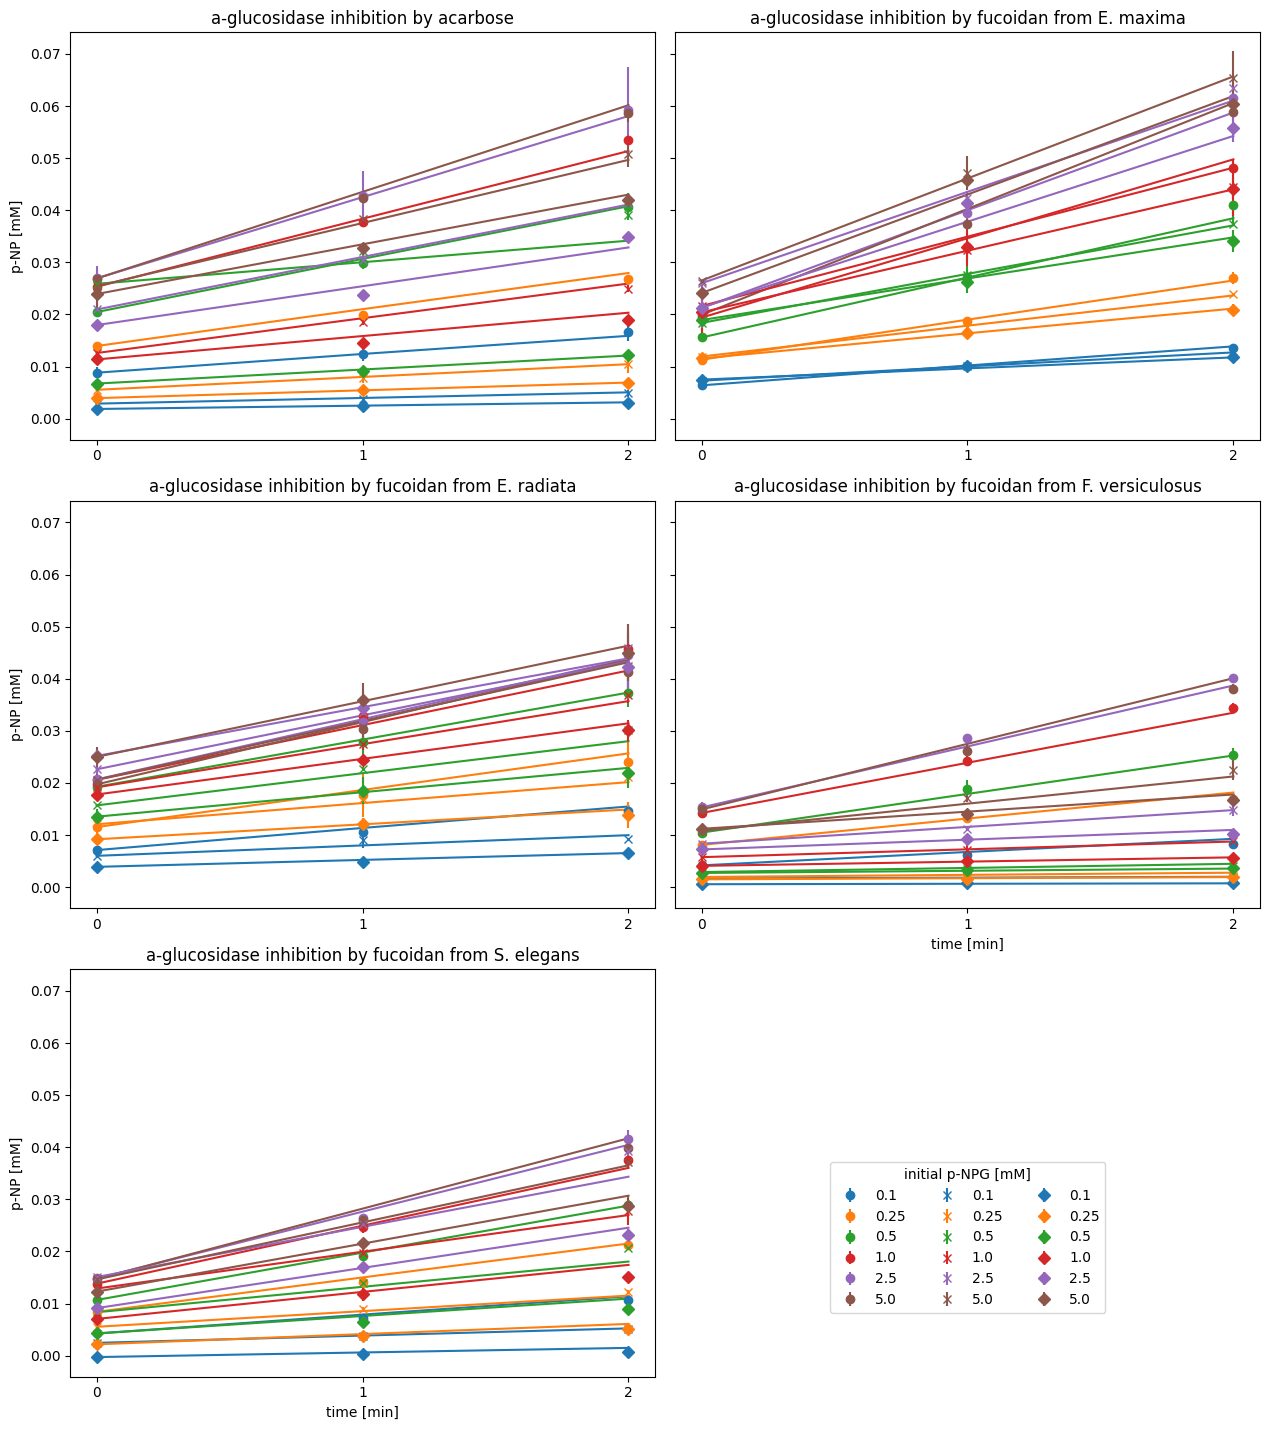

In [113]:
# Visualize fitted competitive inhibition models with measurement data
fig, axes = plt.subplots(3,2, figsize=(12.8, 14.4), sharey=True, sharex=False)
for i, (ax, result) in enumerate(zip(axes.flatten(), results)):
    result.visualize(ax=ax)
    ax.set_xticks([0,1,2])

    if not i%2:
        ax.set_ylabel("p-NP [mM]")
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=3, title="initial p-NPG [mM]", bbox_to_anchor=(0.76,0.08))
fig.delaxes(axes[2][1])
axes[1][1].set_xlabel("time [min]")
axes[2][0].set_xlabel("time [min]")
plt.tight_layout()

_Fig. XXX: Fitted competitive inhibition models to the measurement data of the $\alpha$-glucosidase data set_

Fitted competitive inhibition models and the respective measurement data is visualized in figure xxx. Therein, the initial substrate concentration of the reaction is color coded, whereas the applied inhibitor concentration are denoted with different markers (●: without inhibitor, __×__: lower inhibitor concentration, ◆: higher inhibitor concentration). 


In [80]:
def get_parameters(result, model_name: str):
    values = []
    for parameter, value in result.models[model_name].result.params.items():
        values.append(value.value)
    return values

data = {}
for result in results:
    data[result.data.title] = get_parameters(result, "competitive inhibition")

df = pd.DataFrame.from_dict(data).T
df.columns = ["k_cat", "K_m", "K_i"]
df

,k_cat,K_m,K_i
a-glucosidase inhibition by acarbose,1.886400,0.326441,0.111541
a-glucosidase inhibition by fucoidan from E. maxima,2.408644,0.441592,1.090551
a-glucosidase inhibition by fucoidan from E. radiata,1.346504,0.173415,0.028084
a-glucosidase inhibition by fucoidan from F. versiculosus,1.482208,0.405386,0.002668
a-glucosidase inhibition by fucoidan from S. elegans,1.487024,0.243163,0.016257


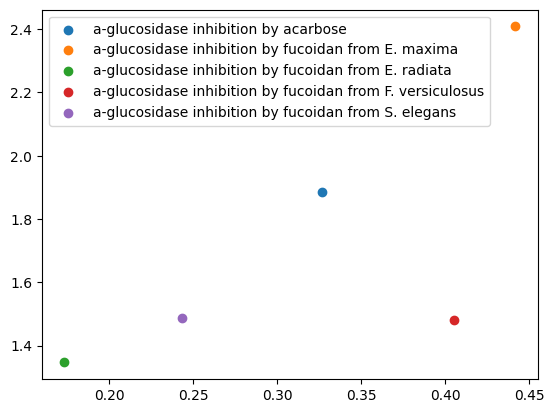

In [119]:
for Km, kcat, label in zip(df["K_m"].values, df["k_cat"].values, df.index):
    plt.scatter(Km, kcat, label=label)
plt.legend()


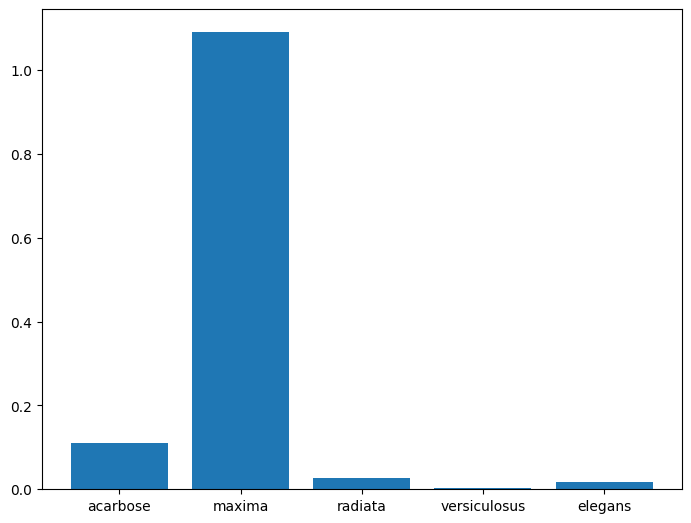

In [81]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
langs = [x.split(" ")[-1] for x in list(df.index)]
students = list(df["K_i"].values)
ax.bar(langs,students)
plt.show()

In [76]:
# Get kinetic parameters of all datasets
kcat = []
kcat_std = []
Km = []
Km_std = []
corr_kcat_km = []
for result in results:
    params = result.get_parameter_dict()

    kcat.append(params["k_cat"].value)
    kcat_std.append(params["k_cat"].stderr)

    Km.append(params["Km"].value)
    Km_std.append(params["Km"].stderr)


    correlation = params["k_cat"].correl
    if correlation == None:
        corr_kcat_km.append(float("nan"))
    else:
        corr_kcat_km.append(correlation["Km"])


df = pd.DataFrame.from_dict({
    'kcat [1/min]':kcat, 
    'kcat stderr':kcat_std, 
    'Km [mM]':Km, 
    'Km stderr':Km_std, 
    "correlation kcat/Km":corr_kcat_km})

df


,kcat [1/min],kcat stderr,Km [mM],Km stderr,correlation kcat/Km
0,1.917804,0.071198,0.406265,0.054363,0.784140
1,2.454626,0.077544,0.585471,0.072166,0.704168
2,1.299105,0.040723,0.176437,0.030107,0.604439
3,1.490314,0.044640,0.362485,0.040119,0.775907
4,1.391455,0.029470,0.255835,0.024337,0.680439


In [83]:
turn_off=False
if turn_off:
    results = []
    for enzmldoc in enzml_docs:
        del enzmldoc.measurement_dict["m6"]
        del enzmldoc.measurement_dict["m7"]
        del enzmldoc.measurement_dict["m8"]
        del enzmldoc.measurement_dict["m9"]
        del enzmldoc.measurement_dict["m10"]
        del enzmldoc.measurement_dict["m11"]
        del enzmldoc.measurement_dict["m12"]
        del enzmldoc.measurement_dict["m13"]
        del enzmldoc.measurement_dict["m14"]
        del enzmldoc.measurement_dict["m15"]
        del enzmldoc.measurement_dict["m16"]
        del enzmldoc.measurement_dict["m17"]
